In [1]:
# Google Colab에서 노트북 실행에 대한 팁은 아래 링크를 참고하세요.
# https://pytorch.org/tutorials/beginner/colab

%matplotlib inline

TorchVision Object Detection Finetuning Tutorial
================================================


이 튜토리얼에서는 사전 학습된 Mask R-CNN 모델을 Penn-Fudan 보행자 탐지 및 세분화 데이터베이스에 맞춰 미세 조정(finetuning)할 것입니다. 이 데이터베이스에는 170장의 이미지와 345개의 보행자 인스턴스가 포함되어 있으며, 이를 활용하여 torchvision의 새로운 기능을 사용하여 사용자 지정 데이터셋에서 객체 탐지(object detection) 및 인스턴스 세분화(instance segmentation) 모델을 학습하는 방법을 설명합니다.

Defining the Dataset
====================

객체 탐지, 인스턴스 세분화, 그리고 사람의 키포인트 탐지를 위한 학습용 참고 스크립트는 새로운 사용자 지정 데이터셋을 쉽게 추가할 수 있도록 지원합니다.  

사용자 지정 데이터셋은 `torch.utils.data.Dataset` 클래스를 상속해야 하며, `__len__`(데이터셋의 총 샘플 수 반환)과 `__getitem__`(개별 샘플을 로드하는 메서드)을 반드시 구현해야 합니다.

우리가 요구하는 유일한 특수 사항은 데이터셋의 `__getitem__` 메서드가 튜플을 반환해야 한다는 것입니다.

- **image**: `torchvision.tv_tensors.Image` 형식의 `[3, H, W]` 크기 텐서, 순수 텐서 또는 `(H, W)` 크기의 PIL 이미지  
- **target**: 다음 필드를 포함하는 딕셔너리:
    - `boxes`: `torchvision.tv_tensors.BoundingBoxes` 형식의 `[N, 4]` 크기 텐서, `N`개의 바운딩 박스의 좌표를 `[x0, y0, x1, y1]` 형식으로 나타냅니다. `x0`, `y0`는 왼쪽 상단, `x1`, `y1`은 오른쪽 하단 좌표로, `0`부터 `W`와 `0`부터 `H` 범위입니다.

    - `labels`: `torch.Tensor` 형식의 정수 텐서 `[N]`, 각 바운딩 박스에 대한 레이블을 나타냅니다. `0`은 항상 배경 클래스를 나타냅니다.

    - `image_id`: 정수로, 이미지 식별자입니다. 데이터셋의 모든 이미지에서 고유해야 하며, 평가 중에 사용됩니다.

    - `area`: `torch.Tensor` 형식의 실수 텐서 `[N]`, 바운딩 박스의 면적을 나타냅니다. COCO 메트릭 평가에서 작은, 중간, 큰 박스 간의 메트릭 점수를 구분하는 데 사용됩니다.

    - `iscrowd`: `uint8` 형식의 `torch.Tensor` 텐서 `[N]`, `iscrowd=True`로 설정된 인스턴스는 평가 중 무시됩니다.
    
    - (선택적으로) `masks`: `torchvision.tv_tensors.Mask` 형식의 `[N, H, W]` 크기 텐서, 각 객체의 세그멘테이션 마스크


만약 데이터셋이 위의 요구사항을 준수한다면, 참조 스크립트의 학습 및 평가 코드 모두에서 작동할 것입니다.  
평가 코드는 `pycocotools`의 스크립트를 사용하며, 이를 설치하려면 `pip install pycocotools` 명령어를 사용할 수 있습니다.


`labels`에 대한 주의사항. 모델은 클래스 `0`을 배경으로 간주합니다.  
만약 데이터셋에 배경 클래스가 포함되지 않는다면, `labels`에 `0`을 포함시키지 않아야 합니다.  
예를 들어, 클래스가 *고양이*와 *개* 두 개만 있다고 가정하면, `1`(0이 아님)을 *고양이*를 나타내는 값으로, `2`를 *개*를 나타내는 값으로 정의할 수 있습니다.  
따라서 예를 들어 하나의 이미지에 두 클래스가 모두 포함되어 있다면, `labels` 텐서는 `[1, 2]`처럼 나타나야 합니다.


추가적으로, 학습 중에 종횡비 그룹화(aspect ratio grouping)를 사용하려면 (즉, 각 배치에 비슷한 종횡비를 가진 이미지들만 포함되도록 하려면), `get_height_and_width` 메서드를 구현하는 것이 좋습니다. 이 메서드는 이미지의 높이와 너비를 반환해야 합니다. 만약 이 메서드가 제공되지 않으면, `__getitem__`을 통해 데이터셋의 모든 요소를 쿼리하게 되며, 이 경우 이미지를 메모리에 로드하는 과정이 포함되므로 사용자 지정 메서드를 제공할 때보다 속도가 느려집니다.


PennFudan 데이터셋을 위한 사용자 지정 데이터셋 작성
--------------------------------------

PennFudan 데이터셋을 위한 데이터셋을 작성해 봅시다. 먼저, 데이터셋을 다운로드하고 [zip 파일](https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip)을 추출합니다:

```python
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
cd data && unzip PennFudanPed.zip


We have the following folder structure:

    PennFudanPed/
      PedMasks/
        FudanPed00001_mask.png
        FudanPed00002_mask.png
        FudanPed00003_mask.png
        FudanPed00004_mask.png
        ...
      PNGImages/
        FudanPed00001.png
        FudanPed00002.png
        FudanPed00003.png
        FudanPed00004.png

여기, 이미지와 세그멘테이션 마스크의 한 쌍 예시가 있습니다:

In [2]:
import matplotlib.pyplot as plt
from torchvision.io import read_image


image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("data/PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

In [3]:
image.shape,mask.shape

(torch.Size([3, 438, 567]), torch.Size([1, 438, 567]))

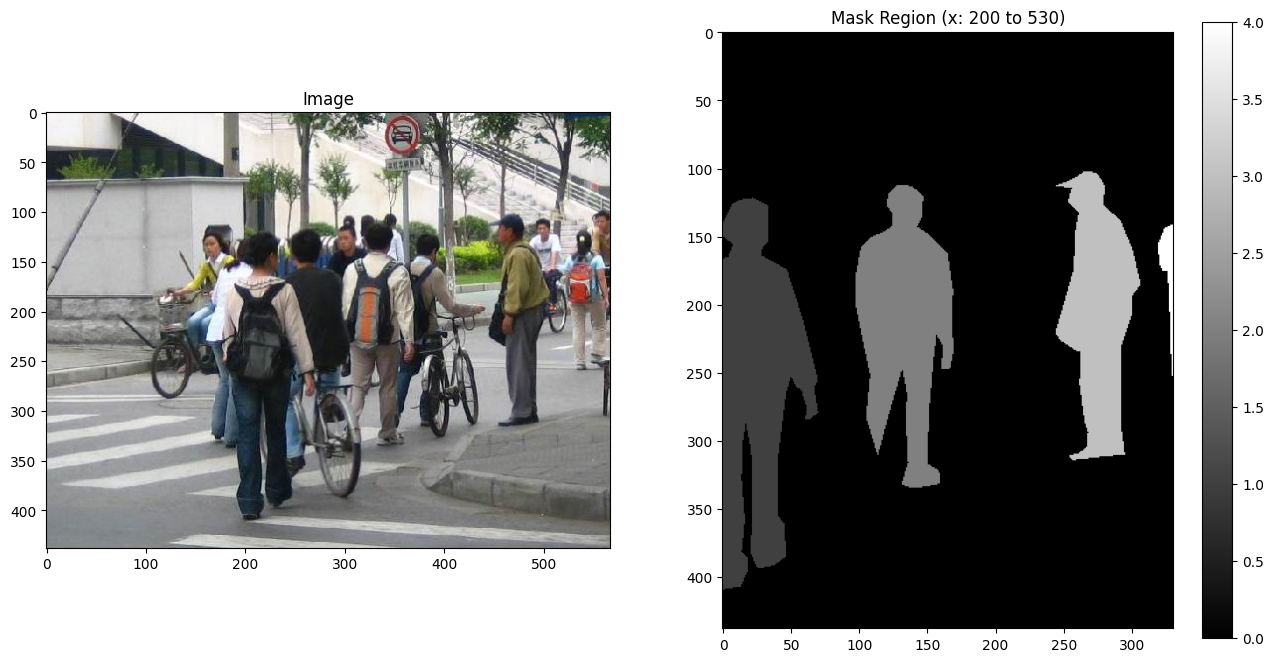

In [4]:
import torch
import matplotlib.pyplot as plt

# x축 범위 200에서 530까지 슬라이싱 (height는 모두 선택)
mask_region = mask[:, :, 200:531]  # x좌표 200부터 530까지

# 결과를 시각화
plt.imshow(mask_region[0].cpu().numpy(), cmap='gray')  # [0]은 배치 차원을 제외한 부분
plt.colorbar()  # 색상 막대 추가 (마스크 값 확인용)
plt.title("Mask Region (x: 200 to 530)")
plt.show()


In [5]:
mask[:,:,200:531]

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

In [6]:
print(torch.unique(mask[:,:,200:531]))


tensor([0, 1, 2, 3, 4], dtype=torch.uint8)


In [7]:
from torchvision.io import read_image 
import torch
torch.set_printoptions(threshold=torch.inf)
read_image(r"C:\PapersWithCode\05_CV\07_Faster_rcnn\data\PennFudanPed\PedMasks\FudanPed00001_mask.png").shape

torch.Size([1, 536, 559])


각 이미지는 해당하는 세그멘테이션 마스크가 있으며, 각 색상은 다른 인스턴스를 나타냅니다. 이 데이터셋을 위한 `torch.utils.data.Dataset` 클래스를 작성해 봅시다. 아래 코드에서는 이미지, 바운딩 박스 및 마스크를 `torchvision.tv_tensors.TVTensor` 클래스로 래핑하여, 주어진 객체 탐지 및 세그멘테이션 작업을 위한 torchvision 내장 변환([새로운 Transforms API](https://pytorch.org/vision/stable/transforms.html))을 적용할 수 있도록 합니다. 즉, 이미지 텐서는 `torchvision.tv_tensors.Image`로 래핑되고, 바운딩 박스는 `torchvision.tv_tensors.BoundingBoxes`로, 마스크는 `torchvision.tv_tensors.Mask`로 래핑됩니다. `torchvision.tv_tensors.TVTensor`는 `torch.Tensor`의 하위 클래스이므로, 래핑된 객체들도 텐서이며 기본 `torch.Tensor` API를 상속받습니다. `torchvision`의 `tv_tensors`에 대한 자세한 내용은 [이 문서](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html#what-are-tvtensors)를 참조하세요.


In [8]:
import os  # 파일 및 디렉토리 경로를 다루기 위한 기본 라이브러리
import torch  # PyTorch 라이브러리
from torchvision.io import read_image  # 이미지를 텐서로 로드하는 함수
from torchvision.ops.boxes import masks_to_boxes  # 마스크로부터 바운딩 박스를 생성하는 함수
from torchvision import tv_tensors  # torchvision에서 제공하는 특수 텐서 (Image, BoundingBoxes, Mask)
from torchvision.transforms.v2 import functional as F  # 이미지 변환 관련 기능 제공


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        """
        PennFudanDataset 클래스의 초기화 함수

        :param root: 데이터셋의 루트 디렉토리 경로
        :param transforms: 이미지 및 어노테이션에 적용할 변환(transform) 함수
        """
        self.root = root  # 데이터셋이 저장된 루트 디렉토리 저장
        self.transforms = transforms  # 데이터 변환 함수 저장

        # 이미지와 마스크 파일 목록을 불러와서 정렬 (파일 이름 순서 유지)
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))  # 이미지 파일 목록
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))  # 마스크 파일 목록

    def __getitem__(self, idx):
        """
        주어진 인덱스(idx)에 해당하는 데이터 샘플을 반환하는 함수

        :param idx: 데이터셋에서 특정 샘플을 가져올 인덱스
        :return: (이미지 텐서, 어노테이션 딕셔너리)
        """
        # 해당 인덱스의 이미지와 마스크 파일 경로 생성
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        # 이미지를 읽어 텐서로 변환 (형태: [C, H, W])
        img = read_image(img_path)

        # 마스크 이미지를 읽어 텐서로 변환 (형태: [1, H, W])
        mask = read_image(mask_path)

        #mask        
        # 0 0 0 0 0 0 0 0
        # 0 1 1 1 0 2 2 2
        # 0 1 1 1 0 2 2 2
        # 0 0 0 0 0 0 0 0



        # 마스크에서 고유한 값(객체 ID) 추출
        obj_ids = torch.unique(mask)  # 모든 픽셀 값에서 유일한 값을 찾음
        #->[0,1,2]
        
        obj_ids = obj_ids[1:]  # 첫 번째 값(배경, 0)을 제외 [1,2]

        # 객체 개수 저장
        num_objs = len(obj_ids)


        # 각 객체 ID에 대해 이진 마스크(0 또는 1) 생성
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
                                #  mask의 차원수는 (1, H, W)
                                #  # [N, 1, 1] -> (예: [3, 1, 1])

        """
            tensor([[[False,  True,  True, False],  # 객체 1 (ID=1)의 마스크
             [False,  True,  True, False],
            [False, False, False, False]],

            [[False, False, False,  True],  # 객체 2 (ID=2)의 마스크
             [False, False, False,  True],
             [False, False, False, False]],

            [[False, False, False, False],  # 객체 3 (ID=3)의 마스크
             [False, False, False, False],
             [False,  True,  True,  True]]])

        """


        # 이진 마스크를 기반으로 객체별 바운딩 박스 생성 (XYXY 형식)
        boxes = masks_to_boxes(masks)

        # 모든 객체는 동일한 클래스(보행자)로 취급 (클래스 ID = 1)
        labels = torch.ones((num_objs,), dtype=torch.int64)

        # 이미지 고유 ID (Faster R-CNN은 이미지 ID를 필요로 함)
        image_id = idx

        # 바운딩 박스의 면적 계산
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # 모든 객체는 "crowd"가 아님 (COCO 데이터셋에서 군집 객체를 나타내는 값, 0 = 개별 객체)
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # 이미지 데이터를 torchvision의 tv_tensors.Image로 변환 (메타데이터 유지)
        img = tv_tensors.Image(img)

        # 타겟 어노테이션 정보를 딕셔너리로 저장
        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))  # 바운딩 박스
        target["masks"] = tv_tensors.Mask(masks)  # 마스크 정보
        target["labels"] = labels  # 클래스 라벨 (1: 보행자)
        target["image_id"] = image_id  # 이미지 ID
        target["area"] = area  # 객체 면적
        target["iscrowd"] = iscrowd  # 객체 군집 여부 (0 = 개별 객체)

        # 변환이 존재할 경우, 이미지와 타겟에 변환 적용 (예: 데이터 증강, 크기 조정)
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target  # 이미지 텐서와 어노테이션 정보 반환

    def __len__(self):
        """
        데이터셋의 크기(총 이미지 개수) 반환

        :return: 데이터셋의 전체 크기 (int)
        """
        return len(self.imgs)  # 이미지 파일 개수를 반환


이제 데이터셋에 대한 부분은 끝났습니다. 이제 이 데이터셋에서 예측을 수행할 수 있는 모델을 정의해 보겠습니다.

모델 정의하기
===================

이 튜토리얼에서는 [Mask R-CNN](https://arxiv.org/abs/1703.06870)을 사용할 것입니다. 이 모델은 [Faster R-CNN](https://arxiv.org/abs/1506.01497)을 기반으로 하고 있습니다. Faster R-CNN은 이미지 내의 잠재적 객체에 대해 바운딩 박스와 클래스 점수를 예측하는 모델입니다.

![image](https://pytorch.org/tutorials/_static/img/tv_tutorial/tv_image03.png)

Mask R-CNN은 Faster R-CNN에 추가적인 분기를 추가하여 각 인스턴스에 대한 세그멘테이션 마스크도 예측합니다.

![image](https://pytorch.org/tutorials/_static/img/tv_tutorial/tv_image04.png)

TorchVision 모델 Zoo에서 사용 가능한 모델을 수정하고자 할 때 두 가지 일반적인 상황이 있습니다. 첫 번째는 미리 훈련된 모델에서 시작하여 마지막 레이어만 파인튜닝하는 경우입니다. 두 번째는 모델의 백본을 다른 것으로 교체하려는 경우 (예: 더 빠른 예측을 위해)입니다.

이제 다음 섹션에서 어떻게 하나 또는 다른 방법을 사용할 수 있는지 살펴보겠습니다.

- 특정 관심 영역(RoI, Region of Interest)을 고정된 크기로 변환하는 연산

1 - 미리 훈련된 모델에서 파인튜닝하기
--------------------------------------

COCO에서 미리 훈련된 모델을 시작으로, 특정 클래스에 대해 파인튜닝하려고 한다고 가정해 봅시다. 이를 수행하는 가능한 방법은 다음과 같습니다:


첫 번째 코드는 ResNet-50 + FPN을 Backbone으로 사용하며, 보다 전통적인 ResNet 기반의 Faster R-CNN 모델을 사용합니다.

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# COCO 데이터셋에서 학습된 모델 불러오기
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
# torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="COCO")


# 분류기에서 감지할 클래스 수를 설정 (1개의 클래스(사람) + 배경)
num_classes = 2  # 1 class (person) + background

# 현재 분류기의 입력 특징 수를 가져옴
in_features = model.roi_heads.box_predictor.cls_score.in_features

# 사전 학습된 헤드를 새로 정의한 헤드로 교체
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [10]:
in_features

1024

In [11]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

2 - Modifying the model to add a different backbone
===================================================


두 번째 코드는 MobileNetV2를 Backbone으로 사용하여 경량화된 Faster R-CNN 모델을 구축하고, RPN과 ROI Pooling을 직접 커스터마이징하여 사용합니다.

In [12]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# 분류를 위한 사전 학습된 모델을 불러오고, 오직 특징(feature)만 반환하도록 설정
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features

print(backbone) # 모델의 기저(기본) 네트워크

# FasterRCNN은 backbone의 출력 채널 수를 알아야 함.
# mobilenet_v2는 1280개의 출력 채널을 가지므로 이를 설정
backbone.out_channels = 1280

# RPN(Region Proposal Network)이 각 공간 위치에서 5개의 크기와 3개의 비율을 가진 5 x 3개의 앵커를 생성하도록 설정
# 각 피처 맵마다 다른 크기와 비율을 가질 수 있으므로 Tuple[Tuple[int]]로 설정
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),  # 5개의 앵커 크기 설정
    aspect_ratios=((0.5, 1.0, 2.0),)    # 3개의 비율 설정
)

# ROI(Region of Interest) 자르기에서 사용할 피처 맵과 자르기 후 크기를 정의
# backbone이 Tensor를 반환하면 featmap_names는 [0]이어야 함. 일반적으로 backbone은 ``OrderedDict[Tensor]``를 반환하며,
# 이때 featmap_names에서 사용할 피처 맵을 선택할 수 있음
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],  # 사용할 피처 맵 이름
    output_size=7,        # 리사이징 후 크기 (7x7 크기)
    sampling_ratio=2      # 샘플링 비율
)

# 이제 위에서 정의한 요소들을 결합하여 Faster R-CNN 모델을 만듬
model = FasterRCNN(
    backbone,                        # backbone 네트워크
    num_classes=2,                    # 1개의 클래스(사람) + 배경
    rpn_anchor_generator=anchor_generator,  # 앵커 생성기
    box_roi_pool=roi_pooler                # ROI 풀링
)


Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

PennFudan 데이터셋을 위한 객체 탐지 및 인스턴스 세그멘테이션 모델
======================================================================

우리의 경우, 데이터셋이 매우 작기 때문에 미리 훈련된 모델에서 파인튜닝하는 방법을 사용하려고 합니다. 따라서 첫 번째 방법을 따를 것입니다.

여기에서는 인스턴스 세그멘테이션 마스크도 계산하려고 하므로, Mask R-CNN을 사용할 것입니다:


In [13]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # COCO 데이터셋에서 사전 학습된 인스턴스 세그멘테이션 모델 불러오기
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # 분류기의 입력 특징 수를 가져오기
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # 사전 학습된 분류기를 사용자 정의 클래스 수에 맞는 새로운 분류기로 교체
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # 마스크 분류기의 입력 특징 수를 가져오기
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256  # 숨겨진 레이어 크기 설정
    # 마스크 예측기를 새로운 예측기로 교체
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,   # 마스크 예측기의 입력 특징 수
        hidden_layer,       # 숨겨진 레이어 크기
        num_classes         # 사용자 정의 클래스 수
    )

    return model


그게 전부입니다. 이제 `model`은 사용자 정의 데이터셋에서 학습하고 평가할 준비가 되었습니다.

모든 것 통합하기
===========================

`references/detection/` 폴더에는 객체 탐지 모델의 학습 및 평가를 간소화하는 여러 도우미 함수들이 있습니다. 여기서는 `references/detection/engine.py`와 `references/detection/utils.py`를 사용할 것입니다. `references/detection` 폴더 아래의 모든 파일을 자신의 폴더에 다운로드하고 여기서 사용하면 됩니다. 리눅스에서는 `wget`이 설치되어 있다면 아래 명령어를 사용하여 다운로드할 수 있습니다:


In [14]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

1

v0.15.0부터 torchvision은 [새로운 Transforms API](https://pytorch.org/vision/stable/transforms.html)를 제공하여 객체 탐지 및 세그멘테이션 작업을 위한 데이터 증강 파이프라인을 쉽게 작성할 수 있습니다.

이제 데이터 증강 / 변환을 위한 몇 가지 도우미 함수를 작성해 보겠습니다:


In [15]:
from torchvision.transforms import v2 as T

def get_transform(train):
    # 변환 리스트 초기화
    transforms = []
    
    # 학습 시, 랜덤 수평 뒤집기 추가 (50% 확률로 뒤집기)
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    
    # 텐서를 float 형으로 변환하고, 값을 [0, 1] 범위로 스케일링
    transforms.append(T.ToDtype(torch.float, scale=True))
    
    # 순수 텐서 형태로 변환
    transforms.append(T.ToPureTensor())
    
    # 변환 리스트를 T.Compose를 사용하여 결합
    return T.Compose(transforms)


`forward()` 메서드 테스트 (선택 사항)
=====================================

데이터셋을 반복하기 전에, 학습 및 추론 시 모델이 샘플 데이터에서 무엇을 기대하는지 확인하는 것이 좋습니다.


In [16]:
import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(0.1184, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1098, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0038, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0109, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


이제 학습과 검증을 수행하는 메인 함수를 작성해 보겠습니다.


In [17]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [ 0/60]  eta: 0:00:34  lr: 0.000090  loss: 3.7797 (3.7797)  loss_classifier: 0.7910 (0.7910)  loss_box_reg: 0.3655 (0.3655)  loss_mask: 2.5691 (2.5691)  loss_objectness: 0.0488 (0.0488)  loss_rpn_box_reg: 0.0052 (0.0052)  time: 0.5713  data: 0.0100  max mem: 1639
Epoch: [0]  [10/60]  eta: 0:00:11  lr: 0.000936  loss: 1.3784 (2.1284)  loss_classifier: 0.4482 (0.4525)  loss_box_reg: 0.2052 (0.2113)  loss_mask: 0.9714 (1.4419)  loss_objectness: 0.0122 (0.0192)  loss_rpn_box_reg: 0.0035 (0.0036)  time: 0.2225  data: 0.0141  max mem: 2559
Epoch: [0]  [20/60]  eta: 0:00:07  lr: 0.001783  loss: 0.7779 (1.4459)  loss_classifier: 0.1948 (0.3285)  loss_box_reg: 0.1925 (0.2083)  loss_mask: 0.3236 (0.8827)  loss_objectness: 0.0189 (0.0216)  loss_rpn_box_reg: 0.0040 (0.0048)  time: 0.1759  data: 0.0132  max mem: 2559
Epoch: [0]  [30/60]  eta: 0:00:05  lr: 0.002629  loss: 0.6417 (1.1716)  loss_classifier: 0.1164 (0.2551)  loss_box_reg: 0.2109 (0.2204)  loss_mask: 0.2361 (0.6725)  loss_ob

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [16]:
from engine import train_one_epoch, evaluate

# GPU가 사용 가능하면 GPU에서 실행하고, 그렇지 않으면 CPU에서 실행
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 데이터셋의 클래스 수 (배경 + 사람)
num_classes = 2

# 데이터셋 로드 및 변환 적용
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

# 데이터셋을 학습(train)과 테스트(test) 세트로 나누기
indices = torch.randperm(len(dataset)).tolist()  # 데이터셋의 인덱스를 랜덤하게 섞음
dataset = torch.utils.data.Subset(dataset, indices[:-50])  # 학습 데이터: 마지막 50개를 제외한 나머지
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])  # 테스트 데이터: 마지막 50개

# 학습 및 검증 데이터 로더 정의
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,  # 한 번에 2개씩 처리
    shuffle=True,  # 데이터 순서를 랜덤하게 섞음
    collate_fn=utils.collate_fn  # 데이터 배치를 올바르게 정리하는 함수
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,  # 한 번에 1개씩 처리
    shuffle=False,  # 순서를 유지
    collate_fn=utils.collate_fn
)

# 모델 생성 (사전 정의된 함수 사용)
model = get_model_instance_segmentation(num_classes)

# 모델을 적절한 장치(GPU 또는 CPU)로 이동
model.to(device)

# 옵티마이저(Optimizer) 설정
params = [p for p in model.parameters() if p.requires_grad]  # 학습 가능한 파라미터만 선택
optimizer = torch.optim.SGD(
    params,
    lr=0.005,  # 학습률(learning rate)
    momentum=0.9,  # 모멘텀 (SGD 가속을 위한 하이퍼파라미터)
    weight_decay=0.0005  # 가중치 감소 (L2 정규화)
)

# 학습률 스케줄러 설정 (3 epoch마다 학습률 감소)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,  # 3 epoch마다
    gamma=0.1  # 학습률을 0.1배로 감소
)

# 학습할 에포크 수 설정
num_epochs = 2

for epoch in range(num_epochs):
    # 1 epoch 동안 학습 실행 (10번마다 진행 상황 출력)
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # 학습률 업데이트
    lr_scheduler.step()
    # 테스트 데이터셋에서 평가 실행
    evaluate(model, data_loader_test, device=device)

print("모델 학습 완료!")


Epoch: [0]  [ 0/60]  eta: 0:00:33  lr: 0.000090  loss: 4.7185 (4.7185)  loss_classifier: 0.6781 (0.6781)  loss_box_reg: 0.2490 (0.2490)  loss_mask: 3.7845 (3.7845)  loss_objectness: 0.0029 (0.0029)  loss_rpn_box_reg: 0.0040 (0.0040)  time: 0.5620  data: 0.0090  max mem: 1867
Epoch: [0]  [10/60]  eta: 0:00:10  lr: 0.000936  loss: 1.7231 (2.3433)  loss_classifier: 0.4810 (0.4433)  loss_box_reg: 0.2383 (0.2453)  loss_mask: 0.8818 (1.6392)  loss_objectness: 0.0082 (0.0114)  loss_rpn_box_reg: 0.0029 (0.0042)  time: 0.2082  data: 0.0113  max mem: 2483
Epoch: [0]  [20/60]  eta: 0:00:07  lr: 0.001783  loss: 0.7988 (1.5152)  loss_classifier: 0.1993 (0.3042)  loss_box_reg: 0.2171 (0.2224)  loss_mask: 0.3008 (0.9738)  loss_objectness: 0.0079 (0.0093)  loss_rpn_box_reg: 0.0034 (0.0054)  time: 0.1663  data: 0.0114  max mem: 2483
Epoch: [0]  [30/60]  eta: 0:00:05  lr: 0.002629  loss: 0.5968 (1.2274)  loss_classifier: 0.1305 (0.2426)  loss_box_reg: 0.2171 (0.2325)  loss_mask: 0.2337 (0.7370)  loss_ob

즉, **한 에포크(epoch) 학습 후**, COCO 스타일의 **mAP(Mean Average Precision)** 값이 50 이상을 기록하고, 마스크(mAP) 값은 **65**에 도달했습니다.  

그렇다면, 모델이 실제로 어떤 예측을 수행하는지 확인해봅시다!  
데이터셋에서 한 이미지를 선택하여 예측 결과를 검증해보겠습니다. 🚀

In [18]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

# 예측할 이미지 로드
image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png")

# 평가(테스트)용 변환 적용
eval_transform = get_transform(train=False)

# 모델을 평가 모드로 설정
model.eval()

# 그라디언트 계산 비활성화 (평가 시 불필요한 연산 방지)
with torch.no_grad():
    x = eval_transform(image)  # 변환 적용
    # RGBA -> RGB 변환 후, 디바이스(GPU 또는 CPU)로 이동
    x = x[:3, ...].to(device)
    predictions = model([x, ])  # 모델에 입력하여 예측 수행
    pred = predictions[0]  # 첫 번째 예측 결과 가져오기

# 이미지 정규화 해제 (0~255 범위로 변환) 후 정수형(uint8)으로 변환
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)

# RGBA 채널 제거 (RGB로 변환)
image = image[:3, ...]

# 예측된 객체들의 레이블과 신뢰도 점수 설정
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]

# 예측된 객체들의 바운딩 박스 좌표 설정 (정수형 변환)
pred_boxes = pred["boxes"].long()

# 이미지에 바운딩 박스 그리기 (빨간색)
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

# 예측된 마스크 (confidence 0.7 이상) 설정
masks = (pred["masks"] > 0.7).squeeze(1)

# 이미지에 세그멘테이션 마스크 그리기 (반투명 파란색)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

# 결과 이미지 출력
plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))  # PyTorch (C, H, W) -> (H, W, C) 변환

# 이미지 파일로 저장
plt.savefig("output_image.png")


### 마무리 🚀  

이번 튜토리얼을 통해 **객체 탐지(Object Detection) 모델을 사용자 지정 데이터셋에서 학습하는 방법**을 배웠습니다.  

이를 위해 다음과 같은 작업을 수행했습니다:  
- `torch.utils.data.Dataset` 클래스를 직접 구현하여 **이미지, 바운딩 박스, 세그멘테이션 마스크**를 반환하도록 설정  
- **COCO train2017 데이터셋**으로 사전 학습된 **Mask R-CNN 모델**을 활용하여 **전이 학습(Transfer Learning)** 수행  

더 **고급 예제**(멀티 머신/멀티 GPU 학습 포함)를 살펴보고 싶다면, **torchvision 저장소**에 있는 `references/detection/train.py`를 참고하세요. 🚀